In [1]:
from _common.database_communicator.db_connector import DBConnector
import pandas as pd
from ml_model.src.data.data_preprocessing import DataPreprocessor
from ml_model.src.models.train_model import XGBoostRegressor
from _common.misc.variables import (
    CATEGORICAL_FEATS,
    NUMERIC_FEATS,
    TARGET_COL,
    FEAT_COLS,
    LOCATION_LIST,
)

In [2]:
preprocessor = DataPreprocessor()
preprocessor.run_preprocessing_pipeline()
df = preprocessor.get()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3062 entries, 10 to 4442
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   status              2676 non-null   category
 1   size                3062 non-null   float64 
 2   property_type       2140 non-null   category
 3   rooms               3056 non-null   float64 
 4   floor               3062 non-null   float64 
 5   year_built          2141 non-null   float64 
 6   property_condition  2490 non-null   category
 7   location            3061 non-null   category
 8   price               3062 non-null   float64 
dtypes: category(4), float64(5)
memory usage: 157.3 KB


In [4]:
df.head()

,status,size,property_type,rooms,floor,year_built,property_condition,location,price
10,pierwotny,-1.053363,kamienica,-1.612758,-0.199468,0.586684,do wykończenia,Stare Miasto,540200.0
11,pierwotny,-0.647273,blok,-0.674515,1.943586,0.586684,NaN,Winogrady,516720.0
12,pierwotny,-0.530990,blok,-0.674515,1.943586,0.586684,NaN,Winogrady,555480.0
13,NaN,0.677919,NaN,1.201970,0.229143,NaN,do wykończenia,Junikowo,782726.0
15,pierwotny,0.988606,blok,1.201970,0.657754,0.586684,do wykończenia,Junikowo,969000.0


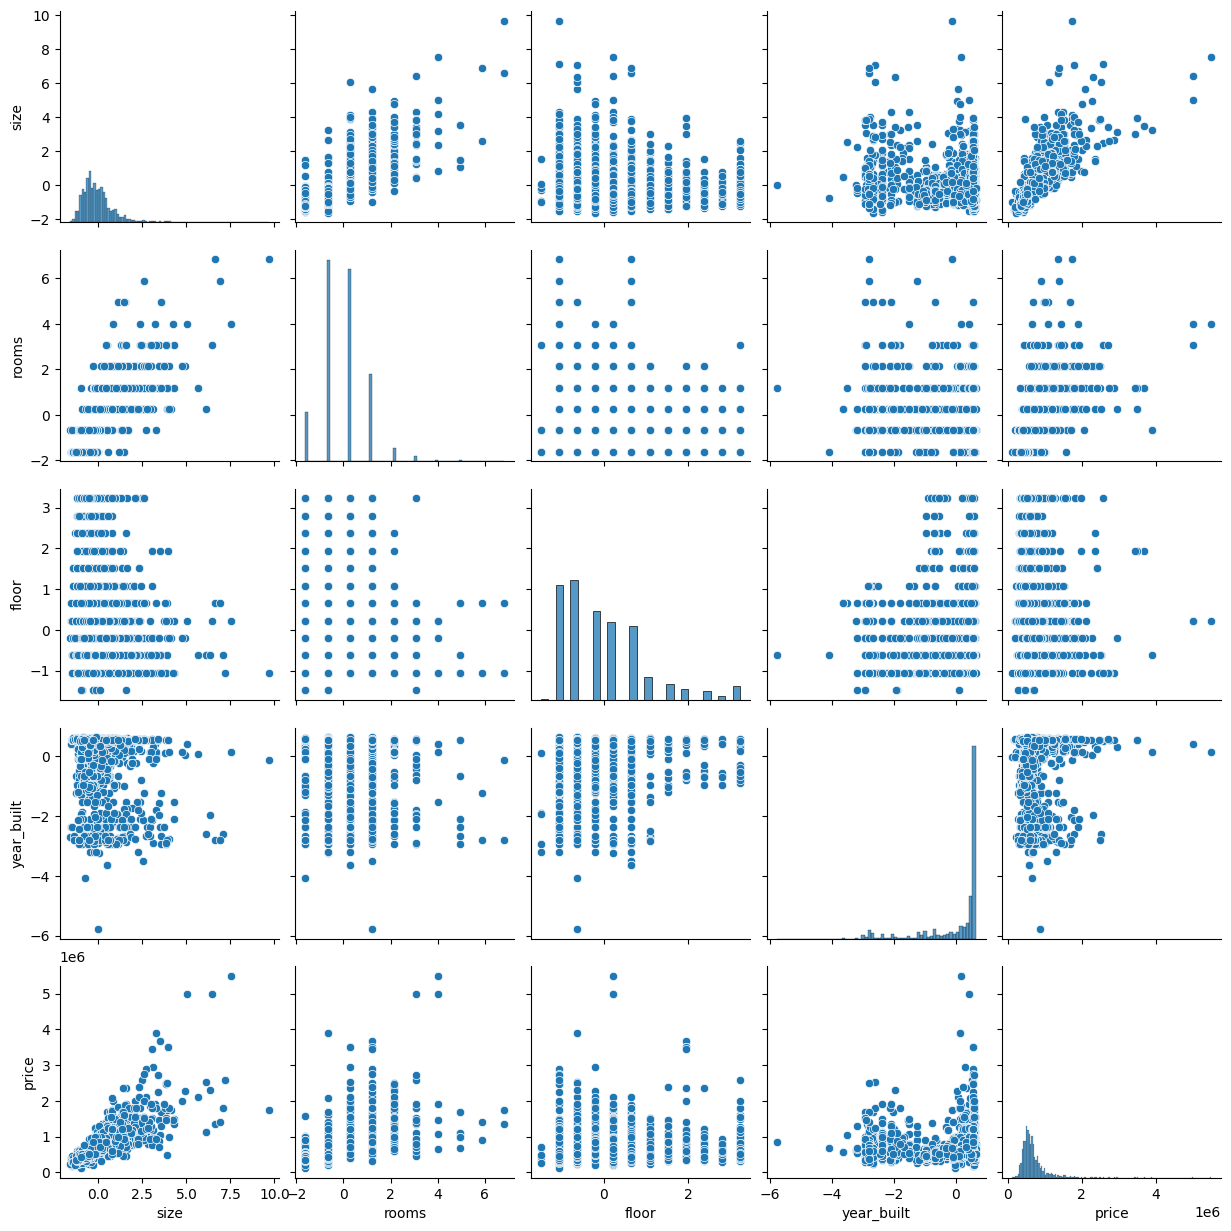

In [5]:
import seaborn as sns

sns.pairplot(df)

In [6]:
cor = df[NUMERIC_FEATS + [TARGET_COL]].corr()
cor.style.background_gradient(cmap="coolwarm", axis=None)

,size,rooms,floor,year_built,price
size,1.000000,0.773280,-0.027160,-0.199292,0.784800
rooms,0.773280,1.000000,-0.045183,-0.080291,0.518689
floor,-0.027160,-0.045183,1.000000,0.021496,0.055881
year_built,-0.199292,-0.080291,0.021496,1.000000,-0.029540
price,0.784800,0.518689,0.055881,-0.029540,1.000000


In [8]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     df[FEAT_COLS], df[TARGET_COL], test_size=0.2, random_state=42
# )

In [7]:
X_train, X_test, y_train, y_test = preprocessor.train_test_split()

In [8]:
X_train.head()

,status,size,property_type,rooms,floor,year_built,property_condition,location
4296,wtórny,-0.556959,blok,-0.672507,-0.200543,-1.041142,do zamieszkania,Łazarz
4140,pierwotny,-0.085941,apartamentowiec,1.198954,-0.628435,0.641745,NaN,Winogrady
871,wtórny,-0.505459,blok,0.263223,-0.628435,NaN,NaN,Rataje
1395,pierwotny,-0.530851,NaN,-0.672507,0.655241,NaN,NaN,Winogrady
2479,pierwotny,-0.476847,blok,-0.672507,-1.056327,0.584698,do wykończenia,Podolany


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[CV] END colsample_bytree=1.0, eta=0.2, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=5, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, eta=0.2, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=5, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, eta=0.3, gamma=0, learning_rate=0.3, max_depth=25, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, eta=0.2, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, eta=0.3, gamma=0, learning_rate=0.3, max_depth=25, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.

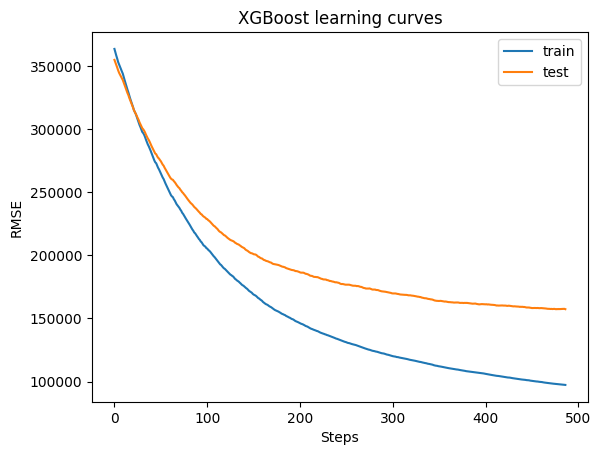

MAE: 73561.58914572863
RMSE: 157334.10042230887
R2: 0.8061583582127478


In [9]:
xgb_regressor = XGBoostRegressor()
xgb_regressor.random_search_cv(X_train, y_train, n_iter=200, random_state=30, verbose=2)
xgb_regressor.train(X_train, y_train, X_test, y_test, verbose=False)
xgb_regressor.plot_learning_curves()
xgb_regressor.evaluate(X_test, y_test)

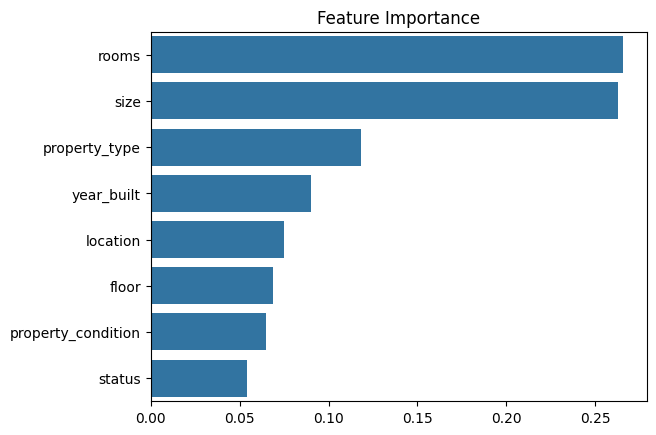

In [10]:
import matplotlib.pyplot as plt

feature_importance = xgb_regressor.feature_importances_
sns.barplot(
    x=feature_importance,
    y=FEAT_COLS,
    order=[FEAT_COLS[i] for i in reversed(feature_importance.argsort())],
)
plt.title("Feature Importance")
plt.show()

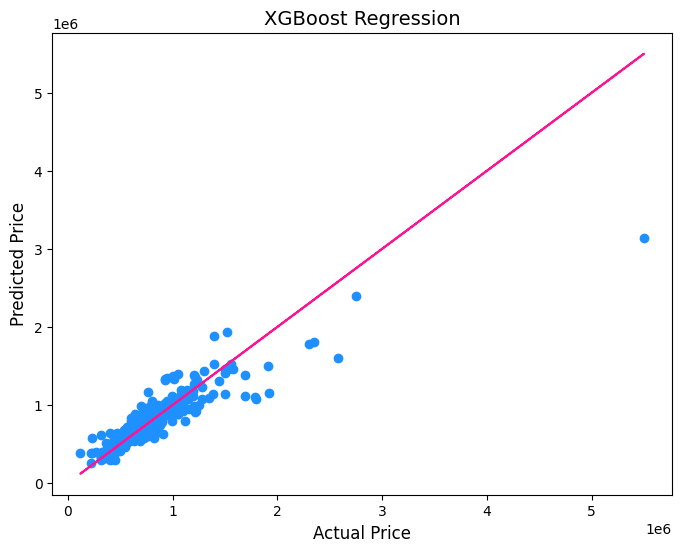

In [11]:
prediction_xgbr = xgb_regressor.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=prediction_xgbr, color="dodgerblue")
plt.plot(y_test, y_test, color="deeppink")
plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("XGBoost Regression", fontsize=14)
plt.show()